# Clustering Catalog Items

## Step 1: Import Libraries

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np                    
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import scipy.cluster.hierarchy as sch
import T2_functions as T2
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import TimeSeriesSplit 
from tqdm import tqdm_notebook
from mlxtend.frequent_patterns import apriori, association_rules
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error

## Step 2: Import and Inspect Data

In [2]:
# Load dataset T2
data = pd.read_csv('t2-dataset.csv')
data.head()

,order_id,city,deliverydate,item_id,itemqty
0,1002,Toronto,2018-01-11 18:50:43,218,12
1,10049,Montreal,2019-03-12 12:16:26,5933,1
2,10049,Montreal,2019-03-12 12:16:26,3131,1
3,10049,Montreal,2019-03-12 12:16:26,1672,15
4,10081,Toronto,2019-03-12 18:23:09,2854,2


In [3]:
# Assign timestamps as indexes of dataframe
format_datetime = '%Y-%m-%dT%H:%M:%S'
data['deliverydate_datetime'] = pd.to_datetime(data['deliverydate'], format=format_datetime)
data = data.set_index(pd.DatetimeIndex(data['deliverydate_datetime']))
data.tail()

,order_id,city,deliverydate,item_id,itemqty,deliverydate_datetime
deliverydate_datetime,,,,,,
2019-02-27 14:30:59,9801,Toronto,2019-02-27 14:30:59,3630,4,2019-02-27 14:30:59
2019-02-28 15:13:46,9829,Toronto,2019-02-28 15:13:46,60246,28,2019-02-28 15:13:46
2018-01-09 15:22:01,986,Toronto,2018-01-09 15:22:01,10,12,2018-01-09 15:22:01
2018-01-09 15:22:01,986,Toronto,2018-01-09 15:22:01,13,56,2018-01-09 15:22:01
2019-03-08 13:15:28,9989,Toronto,2019-03-08 13:15:28,39,20,2019-03-08 13:15:28


In [4]:
# Check whether null values exsit
data.isnull().sum()

order_id                 0
city                     0
deliverydate             0
item_id                  0
itemqty                  0
deliverydate_datetime    0
dtype: int64

In [5]:
# Information about dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18258 entries, 2018-01-11 18:50:43 to 2019-03-08 13:15:28
Data columns (total 6 columns):
order_id                 18258 non-null int64
city                     18258 non-null object
deliverydate             18258 non-null object
item_id                  18258 non-null int64
itemqty                  18258 non-null int64
deliverydate_datetime    18258 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 998.5+ KB


## Step 3: Exploratory Data Analysis

In [6]:
# Identify number of distinct item and order IDs
print('There are '+ str(data['item_id'].nunique()) + ' distinct item IDs (total)')
print('There are '+ str(data['order_id'].nunique()) + ' distinct order IDs (total)')

There are 1788 distinct item IDs (total)
There are 5236 distinct order IDs (total)


In [7]:
# Identify number of distinct item and order IDs for each city

data_Montreal = data[data['city'].str.contains('Montreal')]
data_Toronto = data[data['city'].str.contains('Toronto')]
data_Austin = data[data['city'].str.contains('Austin')]

# Identify number of distinct item and order IDs
print('There are '+ str(data_Montreal['item_id'].nunique()) + ' distinct itemIDs (Montreal)')
print('There are '+ str(data_Montreal['order_id'].nunique()) + ' distinct orderIDs (Montreal)')
print('There are '+ str(data_Toronto['item_id'].nunique()) + ' distinct itemIDs (Toronto)')
print('There are '+ str(data_Toronto['order_id'].nunique()) + ' distinct orderIDs (Toronto)')
print('There are '+ str(data_Austin['item_id'].nunique()) + ' distinct itemIDs (Austin)')
print('There are '+ str(data_Austin['order_id'].nunique()) + ' distinct orderIDs (Austin)')


There are 998 distinct itemIDs (Montreal)
There are 1439 distinct orderIDs (Montreal)
There are 1242 distinct itemIDs (Toronto)
There are 3787 distinct orderIDs (Toronto)
There are 21 distinct itemIDs (Austin)
There are 10 distinct orderIDs (Austin)


In [8]:
# Identify number of overlapping items between cities
items_Montreal = data_Montreal['item_id'].value_counts().index
items_Toronto = data_Toronto['item_id'].value_counts().index
items_Austin = data_Austin['item_id'].value_counts().index

print('ItemsIDs overlap btw Austin and Toronto: ' + str(len(set(items_Austin).intersection(set(items_Toronto)))))
print('ItemsIDs overlap btw Austin and Montreal: ' + str(len(set(items_Austin).intersection(set(items_Montreal)))))
print('ItemsIDs overlap btw Montreal and Toronto: ' + str(len(set(items_Montreal).intersection(set(items_Toronto)))))

ItemsIDs overlap btw Austin and Toronto: 0
ItemsIDs overlap btw Austin and Montreal: 0
ItemsIDs overlap btw Montreal and Toronto: 473


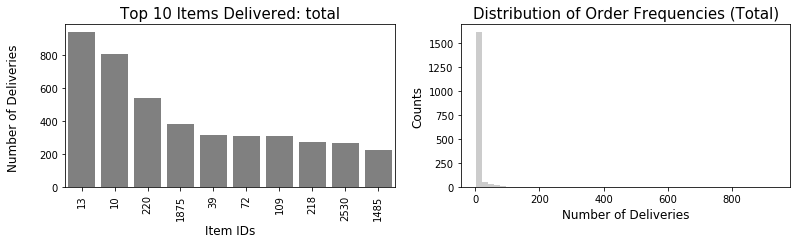

In [9]:
# Plot top-10 items ordered overall and distribution of number of deliveries
T2.plot_top10_dist(data, 'total', 'gray')

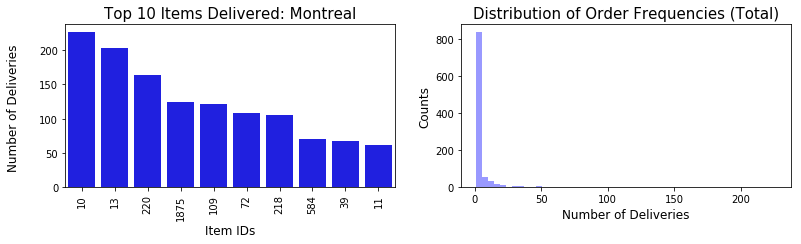

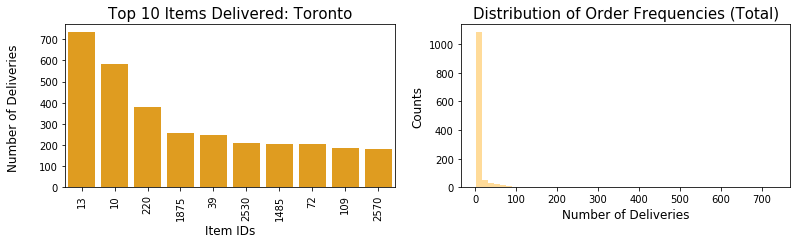

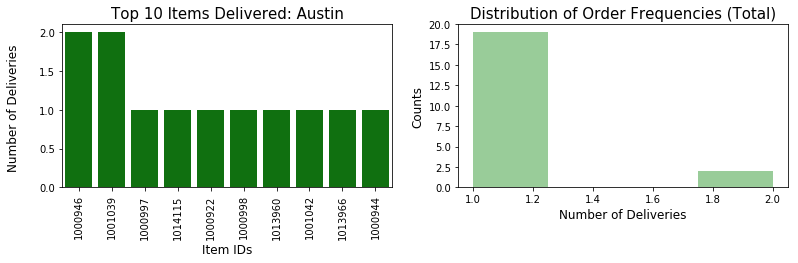

In [10]:
# Plot top-10 items ordered and distribution of number of deliveries in each city
T2.plot_top10_dist(data_Montreal, 'Montreal', 'blue')
T2.plot_top10_dist(data_Toronto, 'Toronto', 'orange')
T2.plot_top10_dist(data_Austin, 'Austin', 'green')

In [11]:
# Create a seperate dataframe for just Montreal and Toronto
data_Montreal_Toronto = data[data['city'].str.contains('Montreal|Toronto')]

## Step 4: Construct OrderID to ItemID Dataframe

In [12]:
# Contruct a matrix of how many times orders appear in each order
basket_sets = T2.OrderID_to_ItemID(data)

## Step 5: Market Basket Analysis

In [13]:
# Compute frequent itemset 
frequent_itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True)

# Calculate association rules
rules = association_rules(frequent_itemsets, metric="lift")
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(13),(10),0.178953,0.154125,0.033995,0.189968,1.232556,0.006414,1.044248
1,(10),(13),0.154125,0.178953,0.033995,0.220570,1.232556,0.006414,1.053394
2,(109),(10),0.059015,0.154125,0.028839,0.488673,3.170623,0.019743,1.654274
3,(10),(109),0.154125,0.059015,0.028839,0.187113,3.170623,0.019743,1.157584
4,(1875),(10),0.072765,0.154125,0.033422,0.459318,2.980157,0.022207,1.564458
5,(10),(1875),0.154125,0.072765,0.033422,0.216853,2.980157,0.022207,1.183985
6,(220),(13),0.103514,0.178953,0.029985,0.289668,1.618678,0.011461,1.155863
7,(13),(220),0.178953,0.103514,0.029985,0.167556,1.618678,0.011461,1.076932


## Step 6: Item Similarity Matrix

In [14]:
# Construct OrderID to ItemID Dataframe
basket_Austin = T2.OrderID_to_ItemID(data_Austin)
basket_Montreal_Toronto = T2.OrderID_to_ItemID(data_Montreal_Toronto)

# Compute correlation matrix
X_Austin = basket_Austin.corr()
X_Montreal_Toronto = basket_Montreal_Toronto.corr()

## Step 7: PCA Dimensionality Reduction

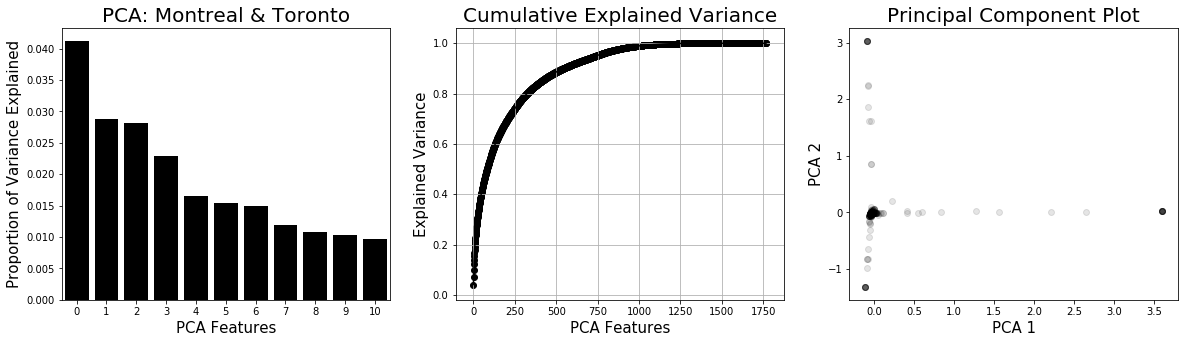

In [15]:
# Perform PCA and keep features that account for 0.75 of variance

# PCA - Montreal and Toronto
X_Montreal_Toronto_reduced = T2.PCA_feature_select(X_Montreal_Toronto, 0.75, 'Montreal & Toronto')
X_Montreal_Toronto_reduced.index = X_Montreal_Toronto.index

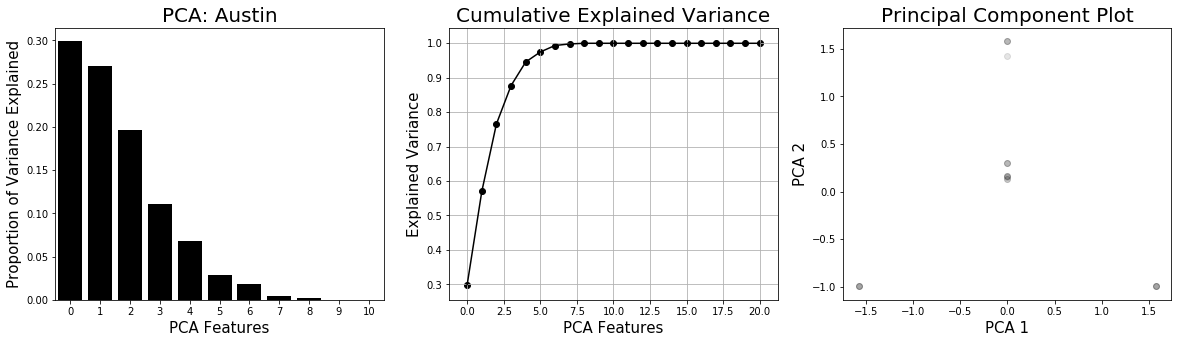

In [16]:
# PCA - Austin
X_Austin_reduced = T2.PCA_feature_select(X_Austin, 0.75, 'Austin')
X_Austin_reduced.index = X_Austin.index

## Step 8: K-means Clustering

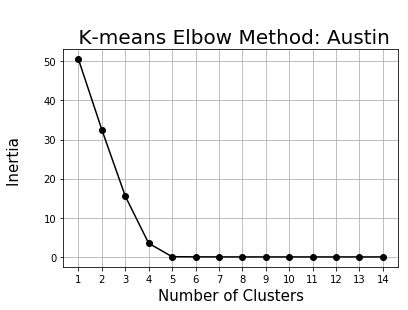

In [17]:
# Elbow method for finding number of k-means clusters
# Elbow method - Austin
T2.Kmeans_no_clusters(X_Austin_reduced, 15, 'Austin')

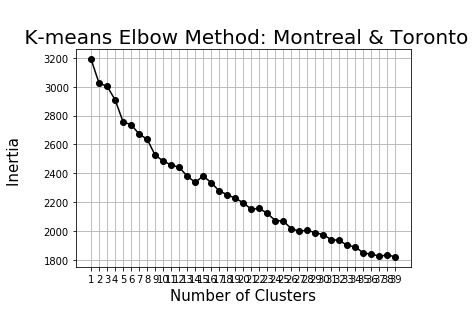

In [18]:
# Elbow method - Montreal and Toronto
T2.Kmeans_no_clusters(X_Montreal_Toronto_reduced, 40, 'Montreal & Toronto')

## Step 9: Hierarchical clustering 

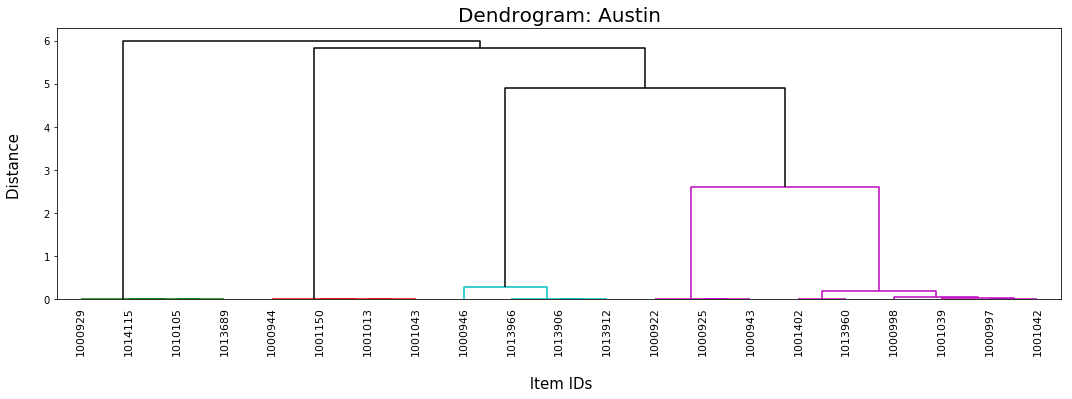

In [19]:
# Visualize dendrogram
# Dendrogram - Austin
T2.dendrogram_visual(X_Austin_reduced, 'Austin')

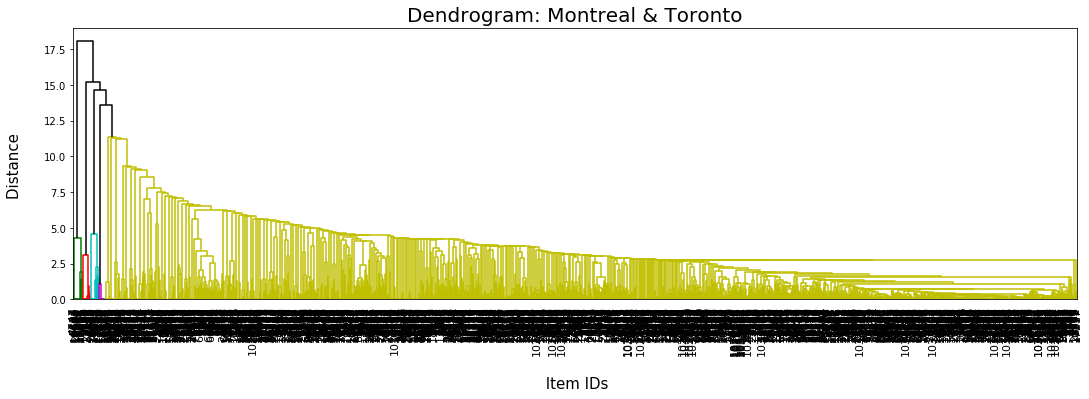

In [20]:
# Dendrogram - Montreal & Toronto'
T2.dendrogram_visual(X_Montreal_Toronto_reduced, 'Montreal & Toronto')

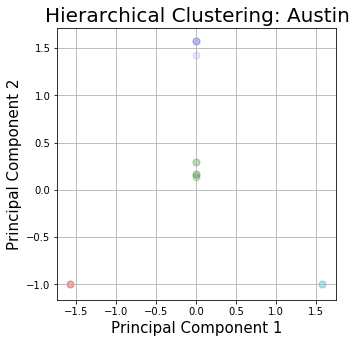

In [21]:
# Locate optmized number of clusters from dendrogram above
Austin_cluster_no = 4
Montreal_Toronto__cluster_no = 5

X_Austin_reduced = T2.Agglomerative_Cluster(X_Austin_reduced, 4, 'Austin')

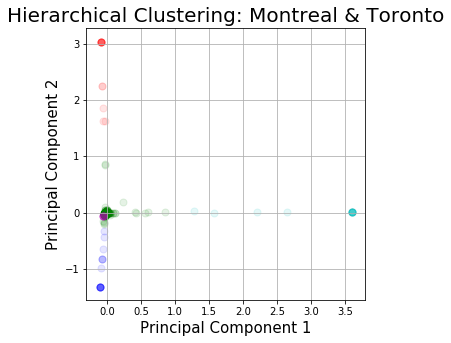

In [22]:
X_Montreal_Toronto_reduced = T2.Agglomerative_Cluster(X_Montreal_Toronto_reduced, 5, 'Montreal & Toronto')

## Step 10: Concatenate and Output Cluster Results

In [23]:
# Offset cluster numbers to distinguish between cities before concatenate
X_Montreal_Toronto_reduced['Labels'] = X_Montreal_Toronto_reduced['Labels'] + Austin_cluster_no

# Concatenate the two dataframes
columns_extract = [0, 'Labels']
frames = [X_Montreal_Toronto_reduced[columns_extract], X_Austin_reduced[columns_extract]]
T2_results = pd.concat(frames)
T2_results.sort_values(by=['Labels'],  inplace=True)
T2_results=T2_results.sort_index()
T2_results = T2_results['Labels']

# Output the cluster results 
# T2_results.to_csv('T2_cluster_results.csv', header = True)